### DOLPHOT Photometry Analysis (w/ artificial star testing)

##### Using UGC 12591 as example

In [52]:
# Imports

import pandas as pd

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as ptc

from astropy.table import Table as tb
from astropy.io import fits
from astropy.wcs import WCS

from scipy import stats as st
from scipy.stats import norm
from scipy import optimize
from scipy.optimize import curve_fit

import emcee
import corner

import os

# For latex plotting warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Read in photometry output
filename = "selected.csv" # csv file containing selected photometry output columns
colnames = ['x_pos', 'y_pos', 'Chi', 'SNR', 'Sharpness', 
            'Roundness', 'Direction', 'Crowding', 'Type', 
            'F606W_mag', 'F606W_unc', 'F814W_mag', 'F814W_unc']

ugc = tb.read(filename, delimiter=' ', names=colnames) # read to astropy table
#ugc

#### X/Y Map

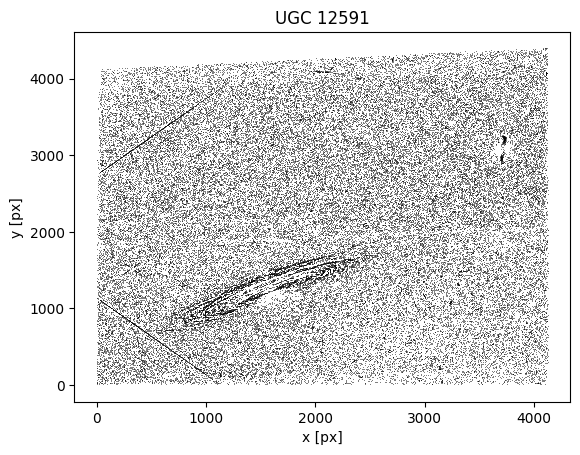

In [3]:
plt.plot(ugc['x_pos'], ugc['y_pos'], 'k,', alpha=0.5)
plt.title('UGC 12591')
plt.xlabel('x [px]')
plt.ylabel('y [px]')
plt.show()

#### Culling the data

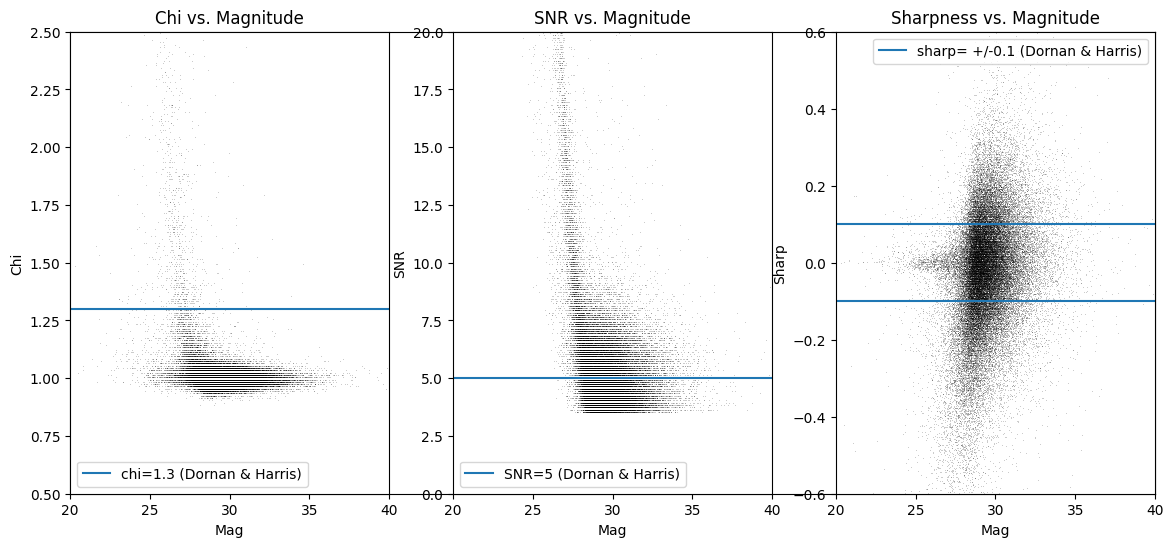

In [4]:
### Plot culling values ###
plt.figure(figsize = (14,6)) # intialize figure
plt.xticks([]) # gets rid of over-laying axis ticks
plt.yticks([])

# Chi
plt.subplot(1,3,1)
plt.title('Chi vs. Magnitude')
plt.plot(ugc['F606W_mag'], ugc['Chi'], 'k,', alpha=0.2)
plt.xlabel('Mag')
plt.ylabel('Chi')
plt.axhline(1.3, label='chi=1.3 (Dornan & Harris)')
plt.xlim(20, 40)
plt.ylim(0.5,2.5)
plt.legend()

# SNR
plt.subplot(1,3,2)
plt.title('SNR vs. Magnitude')
plt.plot(ugc['F606W_mag'], ugc['SNR'], 'k,', alpha=0.2)
plt.xlabel('Mag')
plt.ylabel('SNR')
plt.axhline(5, label='SNR=5 (Dornan & Harris)')
plt.xlim(20, 40)
plt.ylim(0,20)
plt.legend()

# Sharpness
plt.subplot(1,3,3)
plt.title('Sharpness vs. Magnitude')
plt.plot(ugc['F606W_mag'], ugc['Sharpness'], 'k,', alpha=0.2)
plt.xlabel('Mag')
plt.ylabel('Sharp')
plt.axhline(0.1, label='sharp= +/-0.1 (Dornan & Harris)')
plt.axhline(-0.1)
plt.xlim(20, 40)
plt.ylim(-0.6,0.6)
plt.legend()

plt.show()

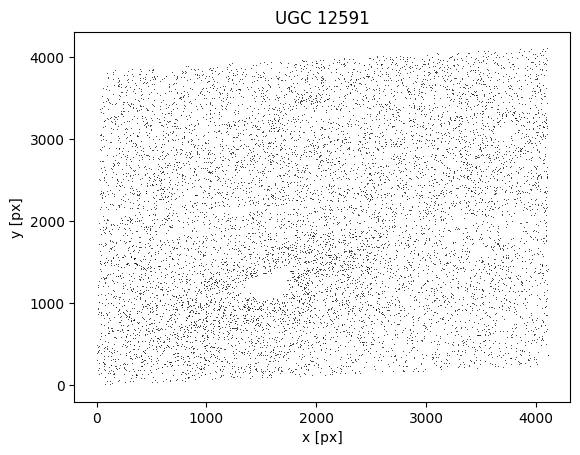

In [5]:
# Cutting out above values
# reject any objects with SNR<5.0, chi > 1.3, or |sharp| > 0.1 (Dornan & Harris 2023)

cull = np.where((ugc['Sharpness'] >= -0.1) & (ugc['Sharpness'] <= 0.1) 
                & (ugc['SNR'] >= 5) & (ugc['Chi'] <= 1.3) & (ugc['F606W_mag'] != 99.999)
               & (ugc['F814W_mag'] != 99.999))

culled = ugc[cull]

# Visualize changes
plt.plot(culled['x_pos'], culled['y_pos'], 'k,', alpha=0.7)
plt.title('UGC 12591')
plt.xlabel('x [px]')
plt.ylabel('y [px]')
plt.show()

#### Get WCS header info to find center of galaxy in pixel values

In [6]:
#### astrometry for centering ####

wcs = WCS(fits.open('ic8q01050_drc.fits')[1].header) # get world coordinate system for image
 
# RA/Dec of center of galaxy from Nasa/IPAC Extragalactic Database
ra_cent, dec_cent = (351.34042,28.49528)
 
# Convert to image pixels
x_cent, y_cent = wcs.all_world2pix(ra_cent, dec_cent, 1, adaptive=False, ra_dec_order=True)
 
# Print results
print('RA: {}, Dec:{} converts to Pixel ({}, {})'.format(ra_cent, dec_cent, x_cent, y_cent))

RA: 351.34042, Dec:28.49528 converts to Pixel (1566.8337410622298, 1188.800560392724)


In [7]:
# Function to calculate the distance from the center of the galaxy

def distance_from_center(point, x_center=x_cent, y_center=y_cent):
    """
    Calculate the distance of a given point from a specified center.

    Parameters:
    point (tuple of float): The (x, y) coordinates of the point.
    x_center (float, optional): The x-coordinate of the center (default: x_cent).
    y_center (float, optional): The y-coordinate of the center (default: y_cent).

    Returns:
    float: The Euclidean distance between the point and the center.
    """
    return np.sqrt(np.abs( (point[0]-x_center)**2 + (point[1]-y_center)**2 ))

### Measure detection completeness using artificial stars test

In [8]:
# Read in artificial star test output
fakes = "fake_more_selected2.csv"

colnames = ['true_pos_x', 'true_pos_y', 'counts606', 'mag606', 'counts814', 'mag814', 'x_pos', 'y_pos', # column names
            'Chi', 'SNR', 'Sharpness', 'Roundness', 'Direction', 'Crowding', 'Type', 
            'F606W_mag', 'F606W_unc', 'F814W_mag', 'F814W_unc']

# Read with Pandas DF
ast = pd.read_csv(fakes, delim_whitespace=True, names=colnames)

#### Initial cleaning of artificial stars

In [9]:
# filtering out too bright objects
detected = (ast['F606W_mag'] != 99.999) & (ast['F814W_mag'] != 99.999) # indices where dolphot detected safe magnitudes


# Measured mag must be within 'magrng' of input mag
magrng = 0.5
measmasks = ((ast['F606W_mag']<=ast['mag606']+magrng)&(ast['F606W_mag']>=ast['mag606']-magrng)
                      &(ast['F814W_mag']<=ast['mag814']+magrng)&(ast['F814W_mag']>=ast['mag814']-magrng))


# Includes culling values used on actual data, applied before completeness calculation
filt = ((ast['mag606'] > 18) & (ast['mag814'] > 18) & (ast['F606W_mag'] > 18) & (ast['F814W_mag'] > 18) & 
        detected & measmasks & (ast['Sharpness'] >= -0.1) & (ast['Sharpness'] <= 0.1) & (ast['SNR'] >= 5) & (ast['Chi'] <= 1.3))

filt2 = (detected & measmasks & (ast['Sharpness'] >= -0.1) & (ast['Sharpness'] <= 0.1) & (ast['SNR'] >= 5) & (ast['Chi'] <= 1.3))



filtered = ast.loc[filt2] # filtered ast data (w/o completeness correction)

In [10]:
def radial_masks_linear(xdata, ydata, distance_from_center_func=distance_from_center, 
                 x_center=x_cent, y_center=y_cent, first_ann=200, interval=500, N_ann=12):
    """
    Generate radial annulus masks based on distances from a central point.

    This function creates a series of annular regions around a specified center and 
    generates boolean masks that classify input coordinates into these regions.

    Parameters:
    xdata (array-like): X-coordinates of the data points.
    ydata (array-like): Y-coordinates of the data points.
    distance_from_center_func (function, optional): Function to compute distances from the center.
        Defaults to `distance_from_center`.
    x_center (float, optional): X-coordinate of the center. Defaults to `x_cent`.
    y_center (float, optional): Y-coordinate of the center. Defaults to `y_cent`.
    first_ann (float, optional): Inner radius of the first annulus. Defaults to 200px.
    interval (float, optional): Base interval for annulus spacing. Defaults to 500px.
    N_ann (int, optional): Number of annuli to generate. Defaults to 12.

    Returns:
    list of numpy.ndarray: A list of boolean masks, where each mask corresponds to an 
    annular region and indicates which input points fall within that region.

    Notes:
    - The first half of annuli have finer spacing (`interval / 5`), while the second half 
      uses the full `interval`.
    - The function prints the annulus regions for verification.
    """ 
    # Organizing coordinates
    x = np.array(xdata)
    y = np.array(ydata)
    coords = np.concatenate([x[:,None],y[:,None]], axis=1)

    
    # Define annulus regions
    annulus_regions = []
    i = 0
    second_ann = first_ann + interval/5
    
    inner = first_ann
    outer = second_ann
    
    while i<N_ann:
        if i<N_ann/2:
            annulus_regions.append((inner,outer))
            inner = outer
            outer += interval/5
            i += 1
        else:
            annulus_regions.append((inner,outer))
            inner = outer
            outer += interval
            i += 1

    #print(annulus_regions)
    
    # Calculate the distance of each point from the center
    distances = np.array([distance_from_center_func(point, x_center, y_center) for point in coords])
    
    annulus_masks = []

    # Create masks for each annulus
    for inner_radius, outer_radius in annulus_regions:
        mask = ((distances > inner_radius) & (distances <= outer_radius))
        annulus_masks.append(mask)

    return annulus_masks, annulus_regions

In [11]:
def completeness_model(m, alph, m_lim, b):
    """
    Compute the completeness function based on a logistic model.

    This function models the completeness of detected objects as a function of magnitude 
    using a logistic function, which smoothly transitions from high completeness at 
    bright magnitudes to low completeness at faint magnitudes.

    Parameters:
    m (array-like or float): Magnitude(s) at which to evaluate the completeness function.
    alph (float): Steepness of the completeness curve. Larger values result in a sharper transition.
    m_lim (float): Limiting magnitude where completeness drops significantly.
    b (float): Maximum completeness value (typically ≤ 1).

    Returns:
    array-like or float: The completeness value(s) corresponding to the input magnitude(s), 
    ranging between 0 and b.
    """
    return b/(1+np.exp(alph*(m-m_lim)))

def complete_curve_fitting(completeness_func, completeness_vals, bins, alpha_guess, mlim_guess, b_guess):
    '''
    Fit a curve to the measurement completeness over magnitudes

    completeness_func (function): model function of curve
    completeness_vals (array-like): output of 'grid_mag_completeness'
    bins (array-like) : magnitude bins
    p0 (list): initial guesses for parameters
    '''
    P0 = [alpha_guess, mlim_guess, b_guess] # completeness fit parameter initial guesses
    popts, pcovs = [], []
    
    for i in range(1,len(completeness_vals)+1):
        popt = [0, 0, 0]
        pcov = np.array([[0,0,0], [0,0,0], [0,0,0]])
        popt, pcov = curve_fit(completeness_model, bins, completeness_vals[i-1], p0=P0)
        #print(popt, pcov)
        popts.append(popt)
        pcovs.append(pcov)
        
    
    return popts, pcovs

In [12]:
def radial_mag_completeness(annulus_masks_raw, annulus_masks_filtered, data, filtered_data, inputmag_str, n_bins=50):
    """
    Compute the magnitude completeness across annular regions.

    This function calculates the completeness fraction of detected artificial stars as 
    a function of magnitude within different radial annuli. It bins the input magnitudes, 
    counts detected and input stars in each bin, and computes the completeness ratio.

    Parameters:
    annulus_masks_raw (list of numpy.ndarray): Boolean masks indicating which stars 
        belong to each annular region in the raw input dataset.
    annulus_masks_filtered (list of numpy.ndarray): Boolean masks indicating which 
        stars belong to each annular region in the filtered output dataset.
    data (pandas.DataFrame): The full artificial star test dataset containing all input stars.
    filtered_data (pandas.DataFrame): The filtered dataset containing only detected stars.
    inputmag_str (str): Column name for the input magnitudes in the dataset.
    n_bins (int, optional): Number of bins for magnitude binning. Defaults to 50.

    Returns:
    tuple:
        - bins (numpy.ndarray): Magnitude bin edges used for completeness calculation.
        - completeness (list of numpy.ndarray): A list of completeness arrays, 
          where each array corresponds to an annular region.

    Notes:
    - The first annulus determines the magnitude bin edges used for all regions.
    - Completeness is defined as the ratio of detected stars to input stars in each bin.
    - If a magnitude bin has zero input stars, completeness is set to 0.
    - If completeness exceeds 1 (which may occur due to unexpected filtering effects), 
      the function prints the corresponding annulus, magnitude bin, and completeness value.
    """

    completeness = []
    bins = None  # Initialize bins as None since we will set it in the first iteration

    # Iterate through each annulus region
    for i, (mask_raw, mask_filtered) in enumerate(zip(annulus_masks_raw, annulus_masks_filtered)):

        # Extract input and output magnitude data for the current annulus
        inp_data = data.loc[mask_raw, inputmag_str]
        outp_data = filtered_data.loc[mask_filtered, inputmag_str]

        # Get histogram bins for the first annulus
        if bins is None:
            _, bins = np.histogram(inp_data, bins=n_bins)

        annulus_completeness = []

        # Iterate through each magnitude bin to calculate completeness
        for mag_bin in bins[:-1]:
            # Define the magnitude range
            magfilt_in = (inp_data >= mag_bin) & (inp_data < mag_bin + np.diff(bins)[0])
            magfilt_out = (outp_data >= mag_bin) & (outp_data < mag_bin + np.diff(bins)[0])

            # Count input and output stars
            Ninput = magfilt_in.sum()
            Noutput = magfilt_out.sum()

            # Calculate completeness ratio
            if Ninput > 0:
                ratio = Noutput / Ninput
            else:
                ratio = 0  # No input stars in this bin

            # If ratio exceeds 1, print the annulus, bin, and completeness value
            if ratio > 1:
                print(f"Annulus: {i+1} --> mag bin: {mag_bin} --> completeness = {ratio}")

            annulus_completeness.append(ratio)

        completeness.append(annulus_completeness)

    return bins, completeness

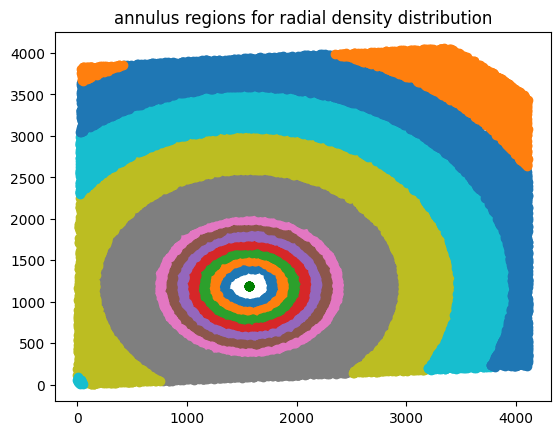

In [15]:
### Defining radial masking regions ###

radial_maskbins_filt = radial_masks_linear(filtered['true_pos_x'], filtered['true_pos_y'])[0]
radial_maskbins_raw = radial_masks_linear(ast['true_pos_x'], ast ['true_pos_y'])[0]


for annulus in radial_maskbins_filt:
    plt.plot(filtered['true_pos_x'][annulus], filtered['true_pos_y'][annulus], 'o')
    plt.plot(x_cent, y_cent, 'go')
    plt.title('annulus regions for radial density distribution')
plt.show()

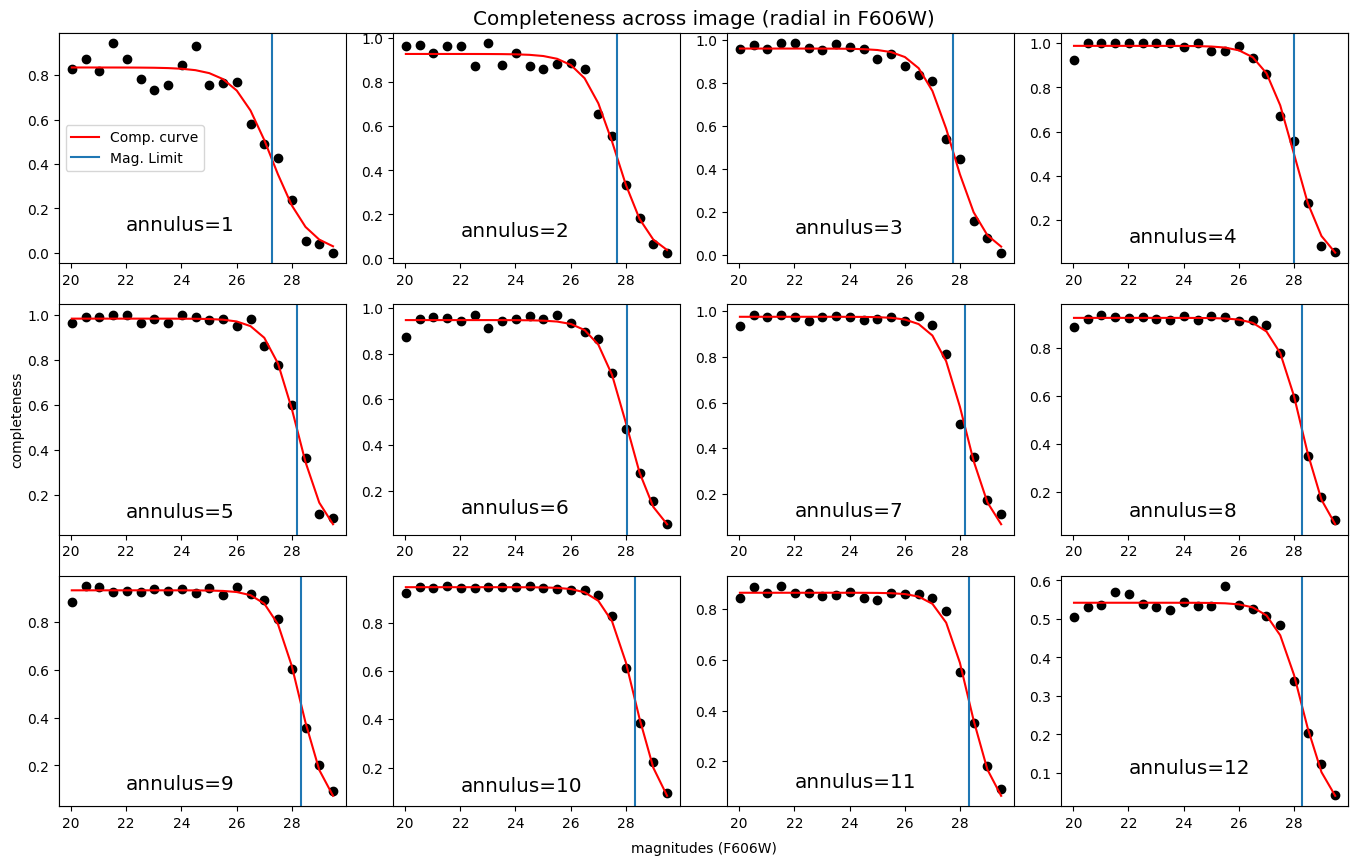

In [16]:
#### Calculating radial completeness's for both pass-bands ####

# First calculate completeness levels, then fit completness curve to find analytical limiting magnitude
ann_complete606 = radial_mag_completeness(radial_maskbins_raw, radial_maskbins_filt, ast, filtered, 'mag606', 20)
curves_rad606 = complete_curve_fitting(completeness_model, ann_complete606[1], ann_complete606[0][:-1], 0.8, 28, 0.9) 

ann_complete814 = radial_mag_completeness(radial_maskbins_raw, radial_maskbins_filt, ast, filtered, 'mag814', 20)
curves_rad814 = complete_curve_fitting(completeness_model, ann_complete814[1], ann_complete814[0][:-1], 0.8, 28, 0.9)


## Plotting in F606W ##
fig, ax = plt.subplots(figsize=(14,9))#, layout='constrained')
ax.set_title('Completeness across image (radial in F606W)', fontsize='x-large')
ax.set_yticks([])
ax.set_xticks([])
ax.set_xlabel('magnitudes (F606W)', labelpad=25.0)
ax.set_ylabel('completeness', labelpad=25.0)
for g in range(1,len(ann_complete606[1])+1):
    plt.subplot(3,4,g)
    plt.plot(ann_complete606[0][:-1], ann_complete606[1][g-1][:], 'ko')
    plt.annotate(f'annulus={g}', (22, 0.1), fontsize='x-large')
    plt.plot(ann_complete606[0][:-1], completeness_model(ann_complete606[0][:-1], curves_rad606[0][g-1][0],curves_rad606[0][g-1][1],curves_rad606[0][g-1][2]), 'r', label='Comp. curve')
    #plt.axhline(0.5*np.max(ann_complete[1][g-1]), c='orange')
    plt.axvline(curves_rad606[0][g-1][1], label='Mag. Limit')
    if g==1:
        plt.legend()

plt.tight_layout()
plt.show()

In [27]:
# Save maglim results results to file for later use
maglims606_rad = np.array([bsf[1] for bsf in curves_rad606[0]])
maglims814_rad = np.array([bsf[1] for bsf in curves_rad814[0]])

## Writing the radial mag limits to a txt file
np.savetxt('rad_maglims_606.csv', maglims606_rad, delimiter=',', fmt='%.5f', header='radlims606')
np.savetxt('rad_maglims_814.csv', maglims814_rad, delimiter=',', fmt='%.5f', header='radlims814')

## Also write all fit parameters to txt file
np.savetxt('rad606_fit_params.csv', np.flip(curves_rad606[0], axis=0), delimiter=',', fmt='%.5f')
np.savetxt('rad814_fit_params.csv', np.flip(curves_rad814[0], axis=0), delimiter=',', fmt='%.5f')

### Implement AST magnitude limiting

In [28]:
# collecting magnitude limits from AST
maglims606_rad = pd.read_csv('rad_maglims_606.csv', delimiter=',')
maglims814_rad = pd.read_csv('rad_maglims_814.csv', delimiter=',')

# Need to turn each list into one conservative estimate for the limiting mag in that pass-band
lim606_rad = np.mean(maglims606_rad)
lim814_rad = np.mean(maglims814_rad)

# Booleans for indexing where the data is within the magnitude limits
maglimited = np.where((culled['F606W_mag'] <= lim606_rad) & (culled['F814W_mag'] <= lim814_rad))

culled_filtered = culled[maglimited]
#culled_filtered

In [29]:
# Define coordinates and magnitude variables
x = np.array(culled_filtered['x_pos'])
y = np.array(culled_filtered['y_pos'])
mag606 = np.array(culled_filtered['F606W_mag'])
mag814 = np.array(culled_filtered['F814W_mag'])

# Put above information to one variable
coords = np.concatenate([x[:,None],y[:,None], mag606[:,None], mag814[:,None]],  axis=1)

# Recalculate the annulus regions across real data
annulus_masks = radial_masks_linear(x,y)[0]
annulus_regions = radial_masks_linear(x,y)[1]

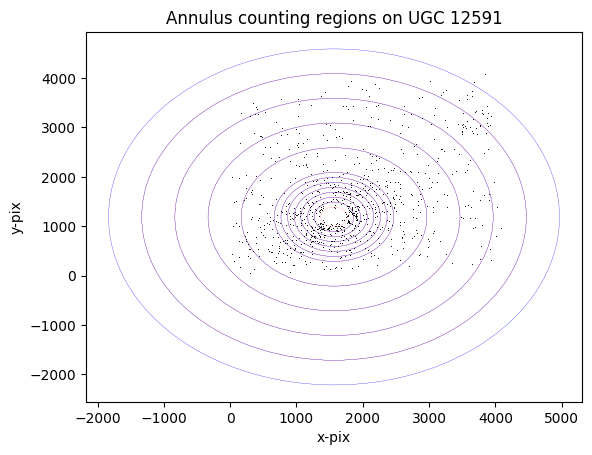

In [30]:
### Visualize annulus regions on galaxy ###
fig = plt.gcf()
ax = fig.gca()
N_ann=12
for i in range(0,N_ann):
    ax.add_patch(ptc.Circle(xy=(x_cent,y_cent), radius=annulus_regions[i][0], fill=False, lw=0.1, color='r'))
    ax.add_patch(ptc.Circle(xy=(x_cent,y_cent), radius=annulus_regions[i][1], fill=False, lw=0.2, color='b'))

plt.plot(culled_filtered['x_pos'], culled_filtered['y_pos'], 'k,', alpha=0.9)
#plt.plot(x_cent,y_cent, 'go')
plt.xlabel('x-pix')
plt.ylabel('y-pix')
plt.title('Annulus counting regions on UGC 12591')
plt.show()

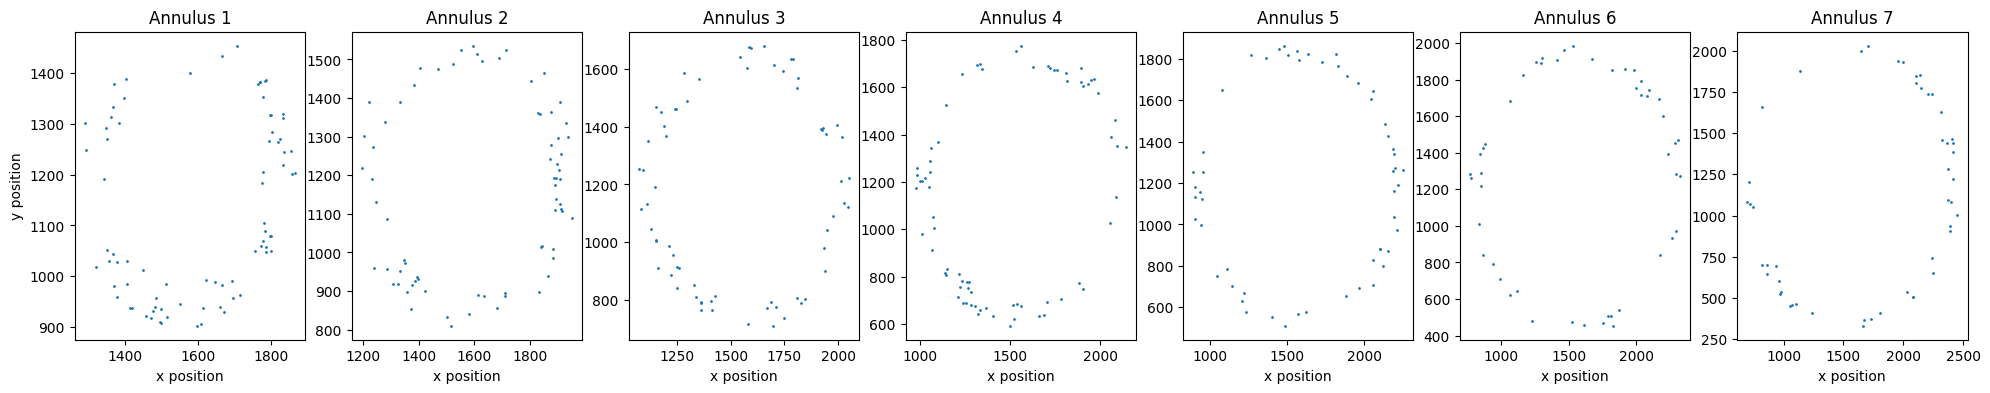

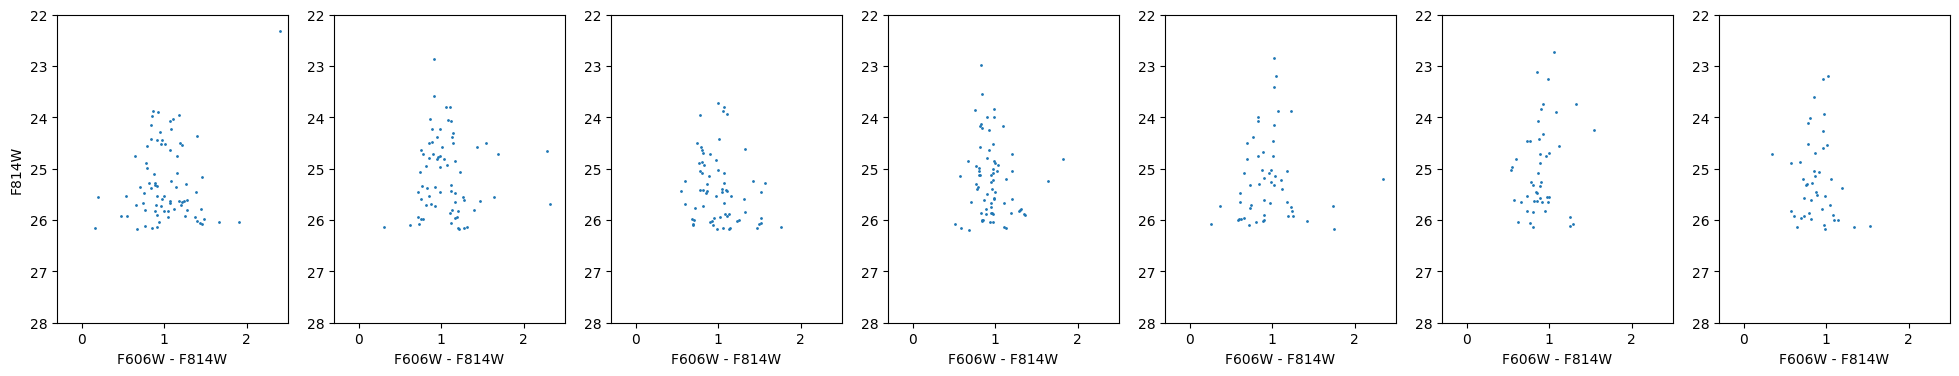

In [31]:
#### Plotting Color-Magnitude Diagrams for each annulus region ####

plt.figure(figsize=(28,4))
for i, mask in enumerate(annulus_masks):
    x_annulus = x[mask]
    y_annulus = y[mask]
    # show points in annulus
    if i<7:
        plt.subplot(1,8,i+1)
        plt.scatter(x_annulus, y_annulus, s=1)
        plt.xlabel('x position')
        if i==0:
            plt.ylabel('y position')
        plt.title(f'Annulus {i+1}')
plt.show()

plt.figure(figsize=(28,4))
for i, mask in enumerate(annulus_masks):
    # show CMD for annulus
        if i<7:
            plt.subplot(1,8,i+1)
            plt.scatter(culled_filtered[mask]['F606W_mag']-culled_filtered[mask]['F814W_mag'], culled_filtered[mask]['F814W_mag'], s=1)
            plt.xlabel('F606W - F814W')
            if i==0:
                plt.ylabel('F814W')
            plt.xlim(-0.3,2.5)
            plt.ylim(28,22)
            #plt.title('CMD')
plt.show()

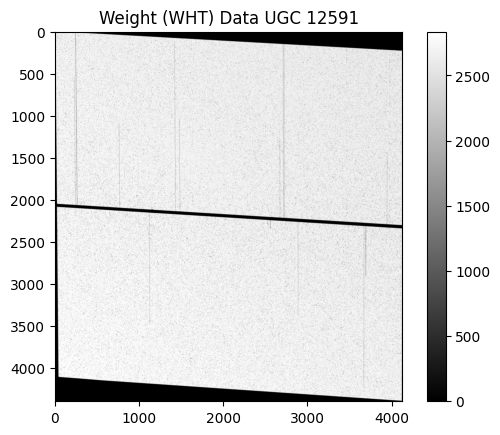

In [33]:
#### Use 'WEIGHT' file in image data to calculate areas of annulus regions ####
#### Pixels with value=0 aren't valid for counting, anything else is set to 1 #

# Get WHT file
file_path = "./ic8q01060_drc.fits"  
with fits.open(file_path) as hdul:
    wht_data = hdul[2].data 
    wht_header = hdul[2].header
    #print(wht_header)

## Make all points >0 equal to 1, such that only valid pixels are including in area counting ##
wht_01 = np.zeros_like(wht_data)
for x in range(len(wht_data)):
    for y in range(len(wht_data[x])):
        if wht_data[x][y] > 0:
            wht_01[x][y]=1

# Visualize
plt.imshow(wht_data, cmap='gray')
plt.colorbar()
plt.title("Weight (WHT) Data UGC 12591")
plt.show()



In [34]:
##### Collect all fit parameters for completeness model function in each annulus ([alph, mlim, b]) (from ast) ####
curves_rad606 = pd.read_csv('rad606_fit_params.csv', delimiter=',', names=['alpha','mlim','b'])
curves_rad814 = pd.read_csv('rad814_fit_params.csv', delimiter=',', names=['alpha','mlim','b'])

### Calculate Radial Area Density Distribution

In [39]:
## Calculate areas and count GCs ##
completeness_vals = [] # initialize list to collect completeness values in

uvis_pltscl = 0.03962 # arcsec/pixel conversion for HST WFC3

# create a distance grid from the galaxy center
ygrid, xgrid = np.indices(wht_01.shape)
grid_distances = np.sqrt((xgrid - x_cent)**2 + (ygrid - y_cent)**2)

# list to store pixel areas for each annulus
annular_arcsec_areas = []
# list to store number of datapoints in each annulus
GC_anncounts = []

for idx, (inner_radius, outer_radius) in enumerate(annulus_regions):
    # define completeness function parameters for given annulus
    alph, m_lim, b = curves_rad606.iloc[idx]
    
    # create a mask for the current annular region
    annulus_mask = (grid_distances >= inner_radius) & (grid_distances < outer_radius)

    # apply the WHT mask to select valid pixels
    valid_annulus_mask = annulus_mask & (wht_01 == 1)

    # calculate the number of VALID pixels in this annular region
    annulus_area = np.sum(valid_annulus_mask)
    annular_arcsec_areas.append((uvis_pltscl**2) * annulus_area)

    # count the number of GCs within annulus
    count = 0
    for point in coords:
        # Calculate distance of the point from the galaxy center
        distance = np.sqrt((point[0] - x_cent) ** 2 + (point[1] - y_cent) ** 2)
        if inner_radius <= distance < outer_radius:
            # Magnitude of the point (assumed to be an attribute or array)
            magnitude = point[2]  # Adjust if magnitude data is stored differently
            # Calculate completeness
            completeness = completeness_model(magnitude, alph, m_lim, b)
            completeness_vals.append(completeness)
            
            if completeness > 0:  # Avoid division by zero
                count += 1 / completeness

    GC_anncounts.append(count)

# Area densities at varying radii from galaxy center
GC_area_dens = np.array(GC_anncounts) / np.array(annular_arcsec_areas )

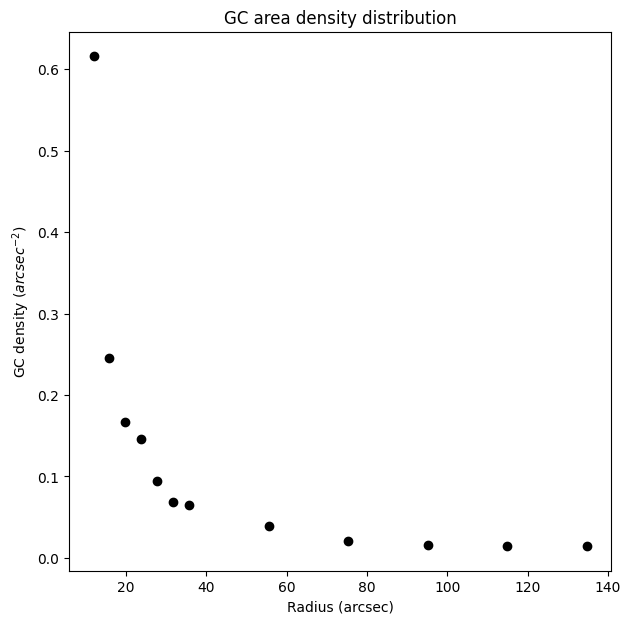

In [41]:
### Visualize distribution ###

# Convert annulus radii from pixels to arcsec
outer_annuli_arcsec = []
for i in range(0,N_ann):
   outer_annuli_arcsec.append(uvis_pltscl*annulus_regions[i][1]) 
#print(outer_annuli_arcsec)

# Plot
fig1, ax1 = plt.subplots(figsize=(7,7))
plt.plot(outer_annuli_arcsec, GC_area_dens, 'ko')
plt.xlabel('Radius (arcsec)')
plt.ylabel('GC density ($arcsec^{-2}$)')

plt.title('GC area density distribution')
plt.show()

### Employ Markov Chain Monte Carlo methods to find numerical solution for distribution parameters

In [105]:
# Reset identifiers for efficiency
x = np.array(outer_annuli_arcsec)/np.max(outer_annuli_arcsec) # normalize radius values for numerical stability
y = GC_area_dens

# Include Poissonian counting noise
sigma = 0.1 * np.sqrt(y)

In [107]:
# Power law model function (w/ constant offset term)
def power_law(x, a, b, k):
    return (a* x**b) + k

# Log-likelihood function
def logLikelihood(params):
    a, b, k = params
    model = power_law(x,a,b,k)
    LL = -0.5 * np.sum(((y - model) / sigma)**2 + np.log(2 * np.pi * sigma**2))
    return LL

# Log-prior function
def logPrior(params):
    a, b, k = params
    if -5 < a < 5 and -10 < b < -1 and -1 < k < 1:
        return 0.0
    return -np.inf

# Log-posterior function
def logPosterior(params):
    return logPrior(params) + logLikelihood(params)

In [108]:
## Run initial direct maximization of log-likelihood ##

o = optimize.minimize(lambda p: -logLikelihood(p), np.array([0.05,-2,0.03]))
print(f"Maximization results:\n--> recovered parameters {o.x} \n--> with covariance matrix\n{o.hess_inv}")

Maximization results:
--> recovered parameters [ 1.86556515e-03 -2.34487094e+00  1.39458206e-02] 
--> with covariance matrix
[[ 2.02824405e-06  4.87731379e-04 -6.76822792e-06]
 [ 4.87731379e-04  1.19203528e-01 -1.55543616e-03]
 [-6.76822792e-06 -1.55543616e-03  5.48264128e-05]]


In [109]:
# Initialize number of parameter dimensions and walkers
ndim = 3
nwalkers = 300

# Run for nsteps steps to get preliminary estimates of parameters & autocorrelation
nsteps = 10000

# Intialize the RNG for reproducible results
np.random.seed(0) 

# Choose initial set of positions for the walkers
p0 = [o.x + 0.1*np.random.rand(ndim) for _ in range(nwalkers)] # randomize

In [110]:
# Initialize the sampler with the chosen specs above
sampler = emcee.EnsembleSampler(nwalkers, ndim, logPosterior)

# run sampling
sampler.run_mcmc(p0, nsteps)

# results
init_samples = sampler.flatchain
mean_params = np.mean(init_samples, axis=0)
std_params = np.std(init_samples, axis=0)
corr = np.corrcoef(init_samples[:, 0], init_samples[:, 1])[0, 1]
acorrt = [int(sampler.get_autocorr_time(tol=5)[i]) for i in [0,1,2]]

print(f"a,b,k estimates: \na {mean_params[0]:.3f}+/-{std_params[0]:.3f}\nb {mean_params[1]:.3f}+/-{std_params[1]:.3f}\nk  {mean_params[2]:.3f}+/-{std_params[2]:.3f}")
#print(f"correlation = {corr: .3f}")
print(f"\nautocorrelation times for a,b,k = {acorrt}")

a,b,k estimates: 
a 0.004+/-0.003
b -2.121+/-0.335
k  0.010+/-0.009

autocorrelation times for a,b,k = [149, 180, 115]


In [111]:
# Burn in steps based on mu1 autocorrelation time
nburn = acorrt[0] * 5

# Run sampling
pos, prob, state = sampler.run_mcmc(p0, nburn) # save the state of sampler after burn sampling

# Reset chain to burn samples but save the state of the sampler
sampler.reset()

In [112]:
# Initialize means and stds for looping
pmean = np.zeros(ndim)
pstd = np.zeros(ndim)
# Intitialize convergence criterion
not_converged = True 
# Initialize counter
nchain = 0 
# Intitialize ncorr for step chunk 
ncorr = acorrt[0]

# Loop until numerical convergence
while not_converged:
    
    # Starting from the last position in the chain, sample nsteps
    pos, prob, state = sampler.run_mcmc(pos, nsteps, rstate0=state)

    # Work in step chunks of length 10*N_corr
    nchain += 10*ncorr
    
    acorr = sampler.get_autocorr_time(tol=10) # autocorrelation time for all parameters
    ncorr = int(acorr[0])                     # choose a single integer value

    # Mean values of the parameters
    pmean_last = np.copy(pmean) # np.copy will reassign pmean_last to pmean from the previous loop before it's redefined
    pmean = np.median(sampler.flatchain[::ncorr], axis=0)

    # std values of the parameters
    pstd_last = np.copy(pstd)
    pstd = np.std(sampler.flatchain[::ncorr], axis=0)
    
    # Numerical convergence criterion
    if nchain > (10*ncorr): # dont check on first realization to avoid divide by 0
        if ((abs((pmean[0]-pmean_last[0]) / pmean_last[0]) < 0.05) & (abs((pstd[0]-pstd_last[0]) / pstd_last[0]) < 0.05)):
            not_converged = False

In [113]:
# View results
print(f"chain length: {nchain}")
print(f"a,b,k estimates: \na {pmean[0]:.3f}+/-{pstd[0]:.3f}\nb {pmean[1]:.3f}+/-{pstd[1]:.3f}\nk  {pmean[2]:.3f}+/-{pstd[2]:.3f}")

chain length: 3220
a,b,k estimates: 
a 0.003+/-0.003
b -2.114+/-0.347
k  0.010+/-0.008


In [114]:
# Corner plots
# corner.corner(sampler.flatchain[::int(np.max(sampler.get_autocorr_time()))], labels=['a', 'b', 'k'],\
#               quantiles=[0.16, 0.5, 0.84], show_titles=True);  

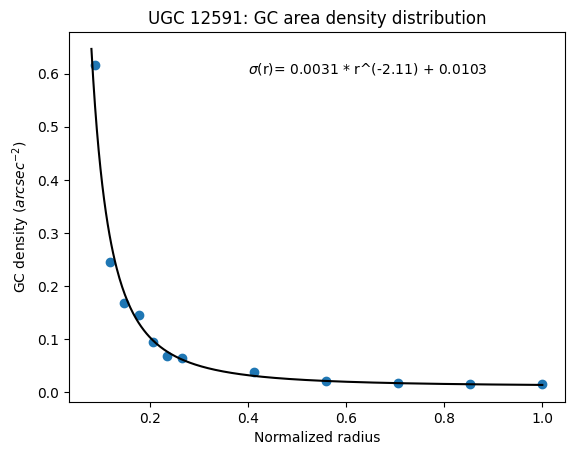

In [118]:
# Visualizing results as best fit curve

plot_x = np.linspace(np.min(x)-0.008,np.max(x), 500)
plt.scatter(x, y)
plt.plot(plot_x, power_law(plot_x, *pmean), 'k')
plt.xlabel('Normalized radius')
plt.ylabel('GC density ($arcsec^{-2}$)')
plt.title('UGC 12591: GC area density distribution')
plt.annotate(f'$\sigma$(r)= {pmean[0]:.4f} * r^({pmean[1]:.2f}) + {pmean[2]:.4f}', (0.4,0.6))
plt.show()

#### Next Steps to Complete the Project (estimate Total Mass in Globular Clusters)
* Background Density Subtraction – Account for background contamination in the cluster distribution.
* Total NGC Calculation – Compute the total number of globular clusters by integrating the density distribution and including contributions from the bulge and faint clusters.
    * Extrapolate the inner bulge cluster density using the highest measured annulus density.
    * Apply a correction for faint, undetectable clusters using the GCLF log-normal distribution.
* Mass Estimation of GCs – Use the mass formula to estimate the total GC system mass, incorporating absolute magnitude data from NED.
